<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Basics-of-camera" data-toc-modified-id="Basics-of-camera-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Basics of camera</a></span><ul class="toc-item"><li><span><a href="#Camera-coordinates" data-toc-modified-id="Camera-coordinates-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Camera coordinates</a></span></li><li><span><a href="#Projection-Matrices" data-toc-modified-id="Projection-Matrices-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Projection Matrices</a></span></li></ul></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset</a></span><ul class="toc-item"><li><span><a href="#Visualizing-the-pointcloud" data-toc-modified-id="Visualizing-the-pointcloud-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Visualizing the pointcloud</a></span></li><li><span><a href="#Dataset-handler" data-toc-modified-id="Dataset-handler-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Dataset handler</a></span><ul class="toc-item"><li><span><a href="#Generators" data-toc-modified-id="Generators-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Generators</a></span></li><li><span><a href="#Visualizing-the-dataset" data-toc-modified-id="Visualizing-the-dataset-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Visualizing the dataset</a></span></li></ul></li></ul></li><li><span><a href="#Disparity" data-toc-modified-id="Disparity-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Disparity</a></span></li><li><span><a href="#Depth-map-from-disparity" data-toc-modified-id="Depth-map-from-disparity-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Depth map from disparity</a></span></li><li><span><a href="#Depth-from-pointclouds" data-toc-modified-id="Depth-from-pointclouds-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Depth from pointclouds</a></span></li><li><span><a href="#Comparing-the-depth" data-toc-modified-id="Comparing-the-depth-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Comparing the depth</a></span></li><li><span><a href="#Visualizing" data-toc-modified-id="Visualizing-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Visualizing</a></span><ul class="toc-item"><li><span><a href="#Difference-between-color-channels" data-toc-modified-id="Difference-between-color-channels-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Difference between color channels</a></span></li></ul></li><li><span><a href="#SIFT-(Scale-Invariant-Feature-Transform)" data-toc-modified-id="SIFT-(Scale-Invariant-Feature-Transform)-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>SIFT (Scale Invariant Feature Transform)</a></span><ul class="toc-item"><li><span><a href="#HOG-(Histogram-of-Gradients)" data-toc-modified-id="HOG-(Histogram-of-Gradients)-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>HOG (Histogram of Gradients)</a></span></li></ul></li><li><span><a href="#RANSAC-(Random-sample-consensus)" data-toc-modified-id="RANSAC-(Random-sample-consensus)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>RANSAC (Random sample consensus)</a></span></li><li><span><a href="#Visual-Odometry" data-toc-modified-id="Visual-Odometry-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Visual Odometry</a></span></li></ul></div>

In [1]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Basics of camera

## Camera coordinates

Right hand rule system
- x direction goes to the right (u for image shown in gray)
- y direction goes down (v for image)
- z direction goes outside from the camera

In this image the ($X_{c}$, $Y_{c}$ and $Z_{c}$) is the coordinate for a point in the environment (world coordinate system) which is observed by the camera coordinate system. This point is captured in the image (shown in gray) by the camera as a point (x,y).

<img src="images/image_coordinate.png" width=800 height=800 />

In [2]:
poses = pd.read_csv('dataset/poses/00.txt', delimiter=' ', header=None)
print('Shape of position dataframe:', poses.shape)
poses.head()
print('First position:')
first_pose = np.array(poses.iloc[0]).reshape((3,4)).round(2)
print(first_pose)

Shape of position dataframe: (4541, 12)
First position:
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1. -0.]]


<IPython.core.display.Javascript object>


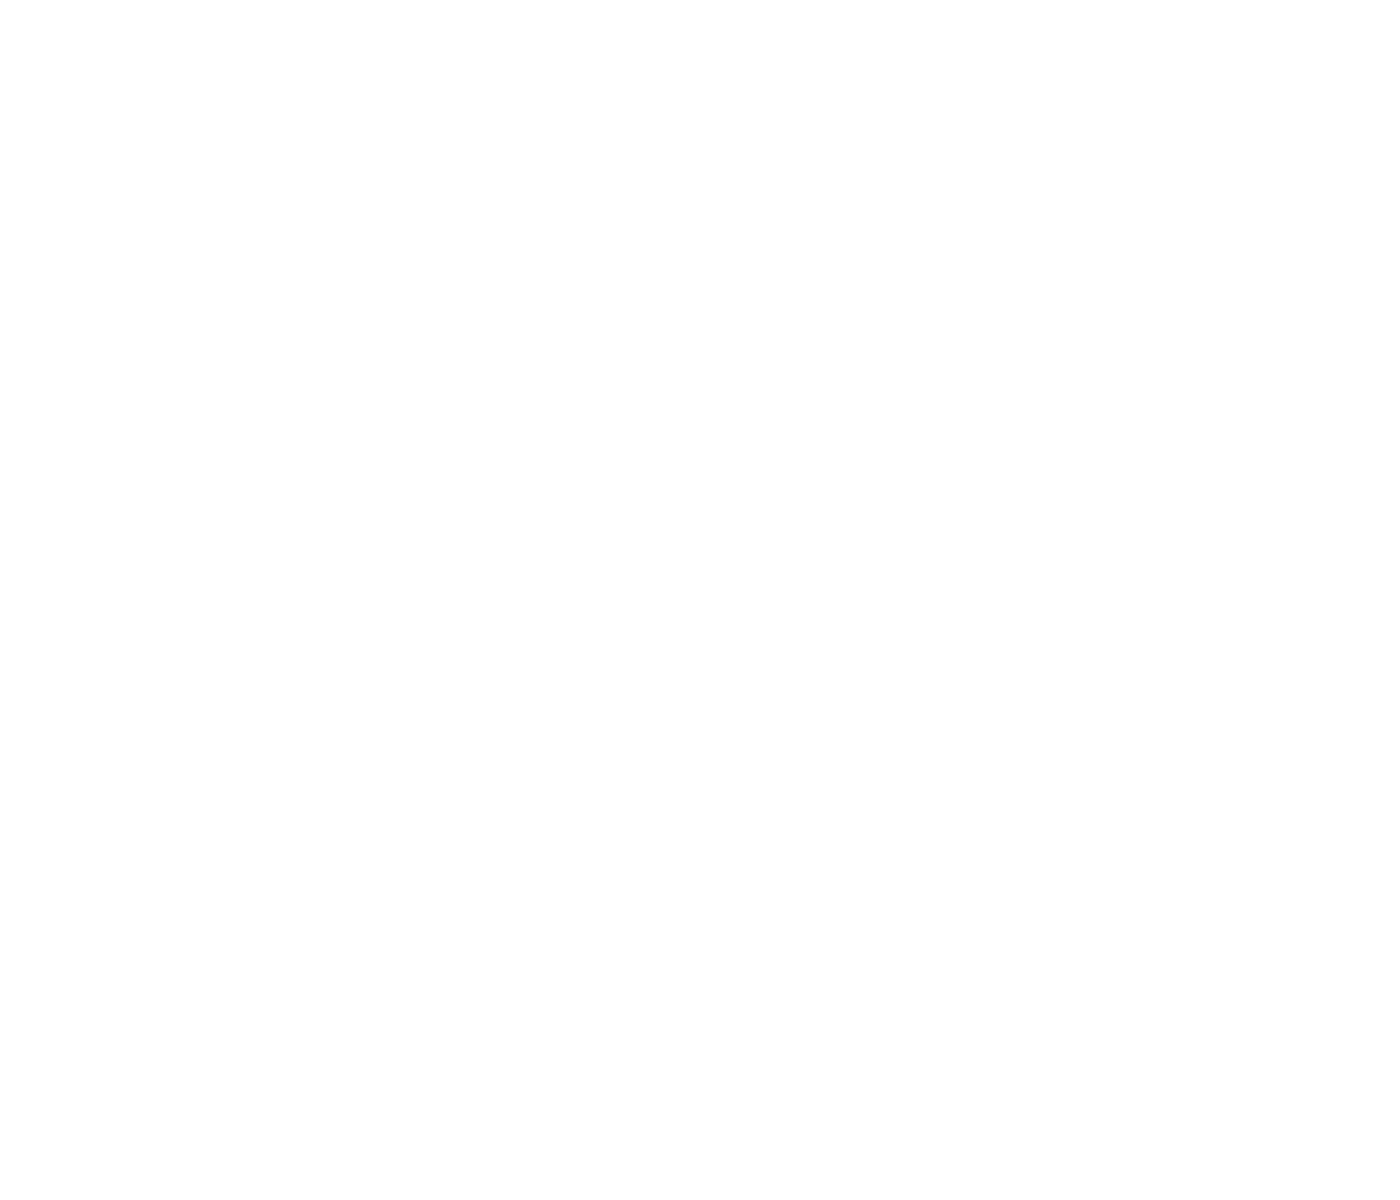

In [3]:
gt = np.zeros((len(poses), 3, 4))
for i in range(len(poses)):
    gt[i] = np.array(poses.iloc[i]).reshape((3, 4))
    
%matplotlib notebook
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(gt[:, :, 3][:, 0], gt[:, :, 3][:, 1], gt[:, :, 3][:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=-40, azim=270)

## Projection Matrices

These matrices contain intrinsic information about the camera's focal length and optical center. Further, they also contain tranformation information which relates each camera's coordinate frame to the global coordinate frame. A projection matrix (3*4) takes 3D coordinates in the global coordinate frame and projects them onto the image plane of the camera through the formula present below.

<img src="images/projection_matrices1.png" width=800 height=800 />

>> NOTE: here $\tau$ is basically the depth of the object from the camera, so we lose the depth information and project everything in the 2d plane.

<img src="images/projection_matrices2.png" width=800 height=800 />

>> NOTE: intrinsic matrix $$ K = \begin{bmatrix} f_{x} & 0 & c_{x} \\ 0 & f_{y} & c_{y} \\ 0 & 0 & 1 \end{bmatrix}$$ where f are the focal point and c is the optical center of the image.

<img src="images/projection_matrices3.png" width=800 height=800 />

In [4]:
# We can load in our sensor calibration data as follows
calib = pd.read_csv('dataset/sequences/00/calib.txt', delimiter=' ', header=None, index_col=0)
calib

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,718.856000,0.000000,607.192800,0.000000,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P1:,718.856000,0.000000,607.192800,-386.144800,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P2:,718.856000,0.000000,607.192800,45.382250,0.000000,718.856000,185.215700,-0.113089,0.000000,0.000000,1.000000,0.003780
P3:,718.856000,0.000000,607.192800,-337.287700,0.000000,718.856000,185.215700,2.369057,0.000000,0.000000,1.000000,0.004915
Tr:,0.000428,-0.999967,-0.008084,-0.011985,-0.007211,0.008081,-0.999941,-0.054040,0.999974,0.000486,-0.007207,-0.292197


In [5]:
# Decomposing a projection matrix with OpenCV
# P = Intrinsic (R|T)
P1 = np.array(calib.loc['P1:']).reshape((3,4))
k1, r1, t1, _, _, _, _ = cv2.decomposeProjectionMatrix(P1)
t1 = t1 / t1[3]
print('Intrinsic Matrix:')
print(k1)
print('Rotation Matrix:')
print(r1)
print('Translation Vector:')
print(t1.round(4))

Intrinsic Matrix:
[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
Rotation Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Translation Vector:
[[ 0.5372]
 [ 0.    ]
 [-0.    ]
 [ 1.    ]]


# Dataset

In [6]:
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

> NOTE: use generator to process a sequence of images

In [7]:
file_path = "dataset/sequences/00/image_0/"
left_images = os.listdir(file_path)
print(" the number of images in this sequence is:", len(left_images))

 the number of images in this sequence is: 4541


<IPython.core.display.Javascript object>


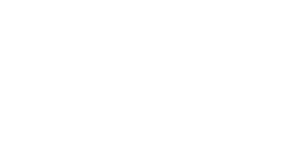

(376, 1241)

In [8]:
plt.figure(figsize=(7,7))
first_image = cv2.imread(file_path + left_images[0], 0)
plt.imshow(first_image)
first_image.shape

## Visualizing the pointcloud

In [9]:
file_path = "dataset/sequences/00/"
velodyne_file_path = os.listdir(file_path + "velodyne")
pointclouds = np.fromfile(file_path + "velodyne/" + velodyne_file_path[0], dtype=np.float32)
# reshaping it to x,y,z and one more value
pointclouds = pointclouds.reshape(-1,4)
pointclouds.shape

(112328, 4)

<IPython.core.display.Javascript object>


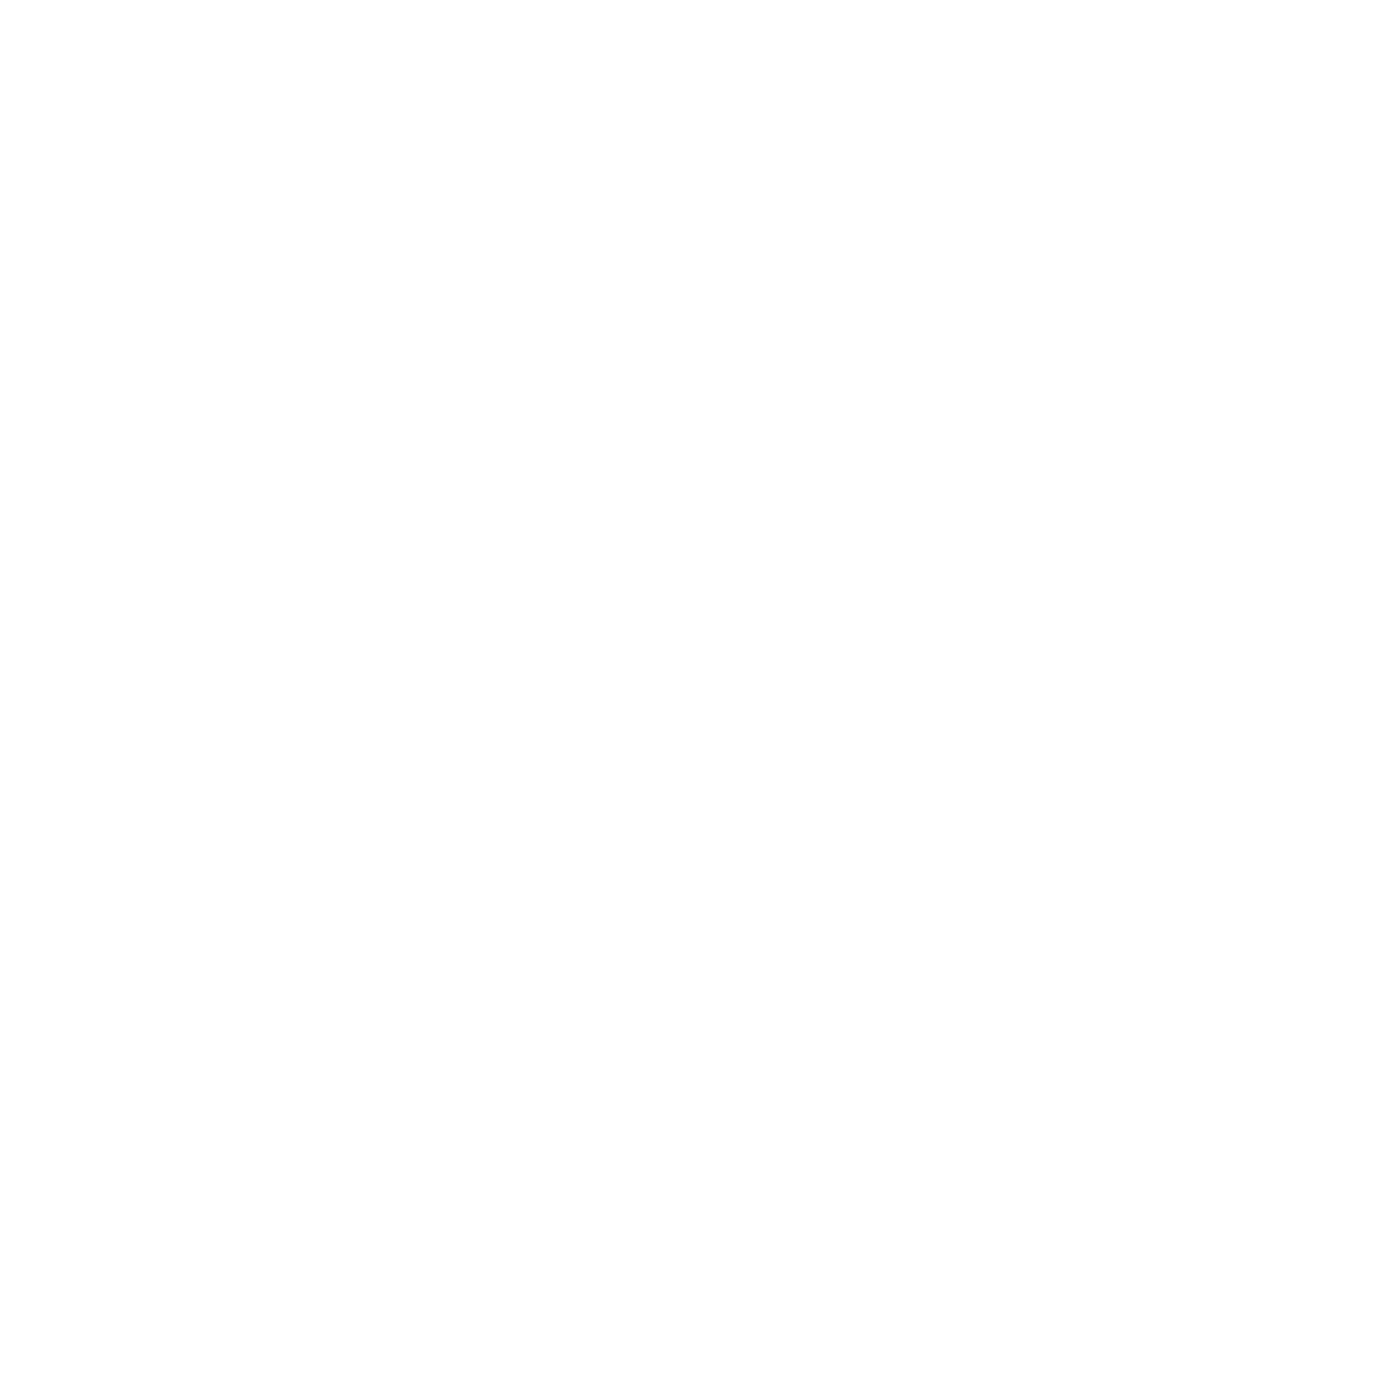

In [10]:
%matplotlib notebook
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111,projection="3d")
x = pointclouds[:,0]
y = pointclouds[:,1]
z = pointclouds[:,2]
ax.set_box_aspect((np.ptp(x),np.ptp(y),np.ptp(z)))
ax.scatter(x,y,z,s=0.01)
ax.grid(False)
ax.axis("off")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(elev=40, azim=100)

## Dataset handler

### Generators

Because the dataset is so bit and will require a lot of ram to load in the memory and store it, it s better to use generators which loads only one element of a sequence at a time. To use a generator use the list comprehension but instead of [ ] use ( ) and the next operator will have the next element and will not save the previous elements.

In [11]:
generators = (i for i in range(1,6))
next(generators)

1

In [12]:
class Dataset_Handler():
    def __init__(self, sequence, lidar=True):
        import pandas as pd
        import os
        import cv2
        
        #if handler contains lidar info
        self.lidar = lidar
        
        #file paths and ground truth poses
        self.seq_dir = 'dataset/sequences/{}/'.format(sequence)
        self.poses_dir = 'dataset/poses/{}.txt'.format(sequence)
        poses = pd.read_csv(self.poses_dir, delimiter=' ', header=None)
        
        #names of files to iterate through
        self.left_image_files = os.listdir(self.seq_dir + 'image_0')
        self.right_image_files = os.listdir(self.seq_dir + 'image_1')
        self.velodyne_files = os.listdir(self.seq_dir + 'velodyne')
        
        self.left_image_files.sort()
        self.right_image_files.sort()
        self.velodyne_files.sort()
        
        self.num_frames = len(self.left_image_files)
        self.lidar_path = self.seq_dir + 'velodyne/'
        
        #calibration details for scene, P0 and P1 are Grayscale cams, P2 and P3 are RGB cams
        calib = pd.read_csv(self.seq_dir + 'calib.txt', delimiter=' ', header=None, index_col=0)
        self.P0 = np.array(calib.loc['P0:']).reshape((3,4))
        self.P1 = np.array(calib.loc['P1:']).reshape((3,4))
        self.P2 = np.array(calib.loc['P2:']).reshape((3,4))
        self.P3 = np.array(calib.loc['P3:']).reshape((3,4))
        # This is the transformation matrix for LIDAR
        self.Tr = np.array(calib.loc['Tr:']).reshape((3,4))
        
        #times and ground truth poses
        self.times = np.array(pd.read_csv(self.seq_dir + 'times.txt', delimiter=' ', header=None))
        self.gt = np.zeros((len(poses), 3, 4))
        for i in range(len(poses)):
            self.gt[i] = np.array(poses.iloc[i]).reshape((3, 4))
        
        #use generators
        self.reset_frames()
        
        #just for testing, store original frame to memory
        self.first_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                           + self.left_image_files[0], 0)
        self.first_image_right = cv2.imread(self.seq_dir + 'image_1/' 
                                           + self.right_image_files[0], 0)
        self.second_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                           + self.left_image_files[1], 0)
        if self.lidar:
            self.first_pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[0],
                                                dtype=np.float32, 
                                                count=-1).reshape((-1, 4))
        self.imheight = self.first_image_left.shape[0]
        self.imwidth = self.first_image_left.shape[1]
            
            
    def reset_frames(self):
        # Resets all generators to the first frame of the sequence
        self.images_left = (cv2.imread(self.seq_dir + 'image_0/' + name_left, 0)
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread(self.seq_dir + 'image_1/' + name_right, 0)
                            for name_right in self.right_image_files)
        if self.lidar:
            self.pointclouds = (np.fromfile(self.lidar_path + velodyne_file, 
                                            dtype=np.float32, 
                                            count=-1).reshape((-1, 4))
                                for velodyne_file in self.velodyne_files)
        pass

In [13]:
handler = Dataset_Handler('00')

### Visualizing the dataset

<IPython.core.display.Javascript object>


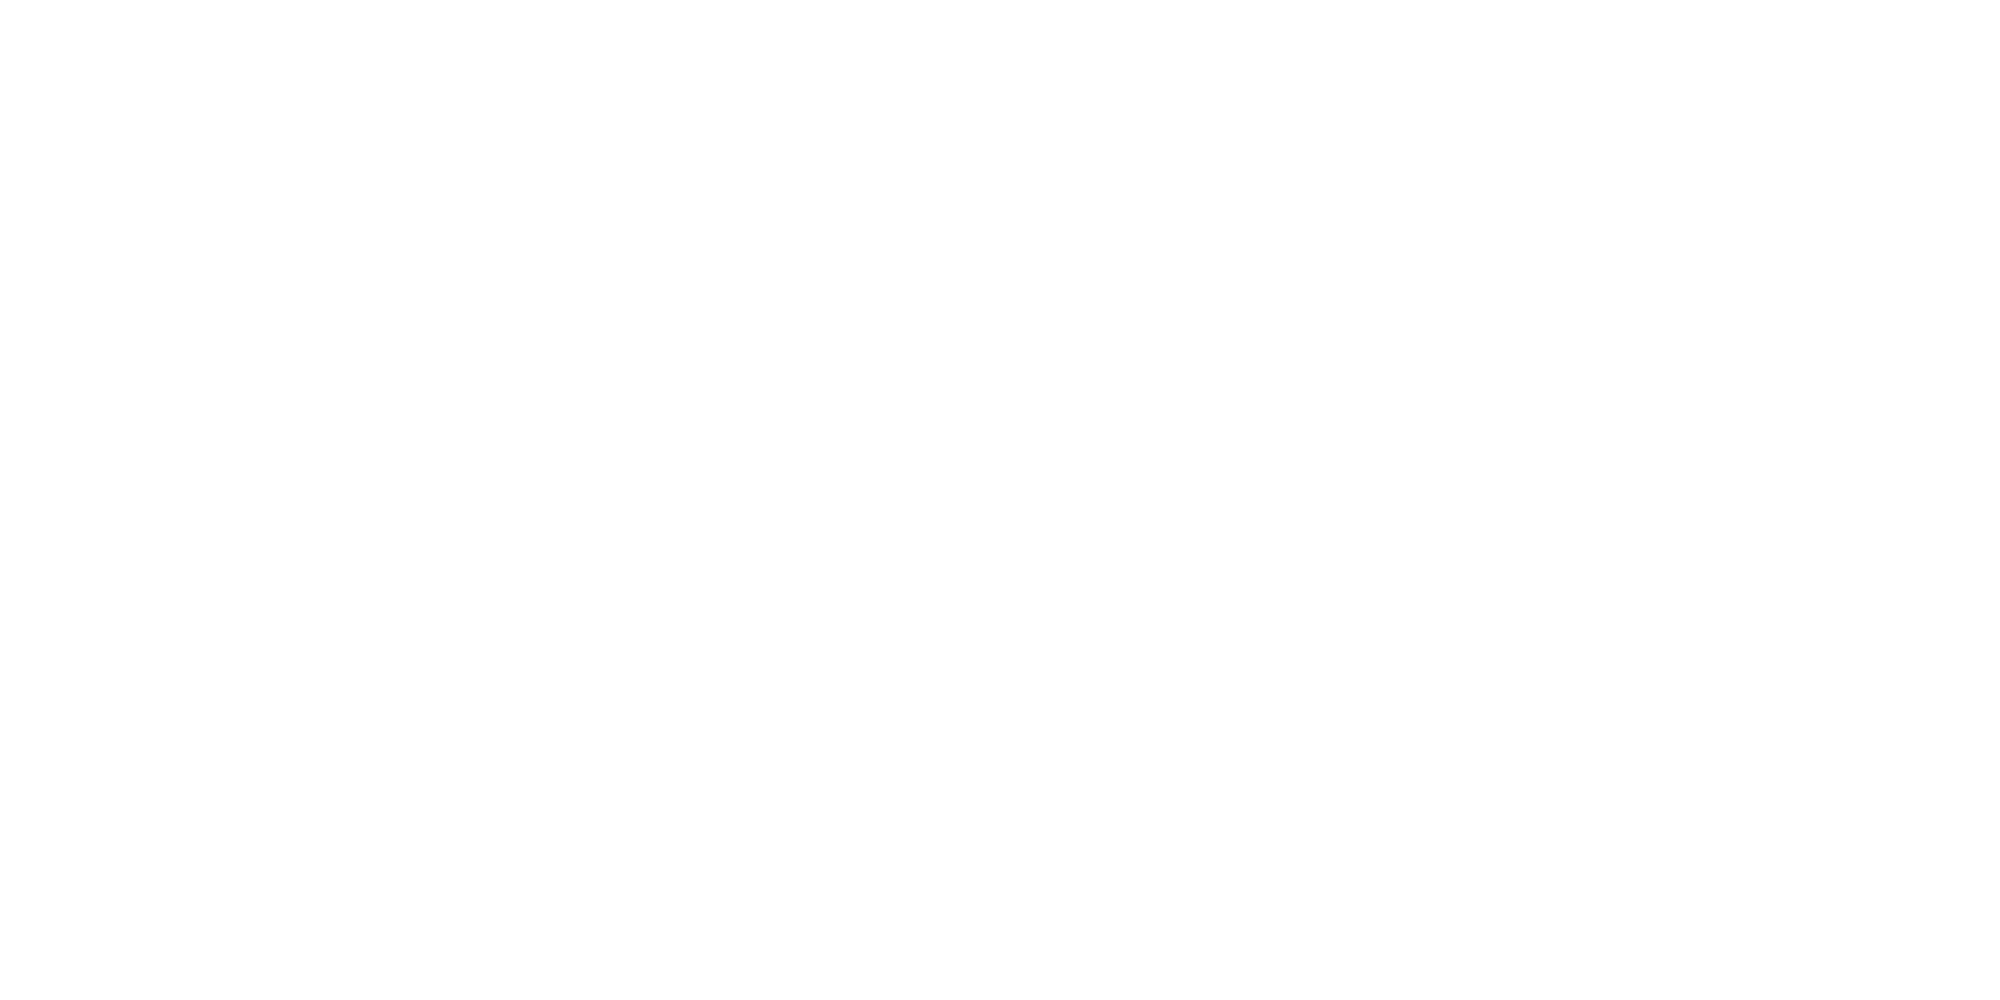

In [14]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.imshow(next(handler.images_left))
ax2.imshow(next(handler.images_right))
ax3.imshow(next(handler.images_left))
ax4.imshow(next(handler.images_right))

# Disparity

The disparity is the apparent motion of objects between a pair of stereo images. To experience this, try closing one eye and then rapidly open it while closing the other one. You will note that closer objects will move significantly while objects further away will move very little.

Given a pair of stereo images, to compute the disparity map, we first match every pixel in the left image with its corresponding pixel in the right image. Then we compute the distance for each pair of matching pixels. Finally, the disparity map is obtained by representing such distance values as an intensity image.

<img src="images/disparity.png" width=900 height=800 />


In [15]:
def compute_left_disparity_map(img_left, img_right, matcher='bm'):
    
    sad_window = 6
    num_disparities = sad_window*16
    block_size = 11
    matcher_name = matcher
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size
                                     )
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 3 * sad_window ** 2,
                                        P2 = 32 * 3 * sad_window ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                       )

    disparity = matcher.compute(img_left, img_right).astype(np.float32)/16
    
    return disparity

<IPython.core.display.Javascript object>


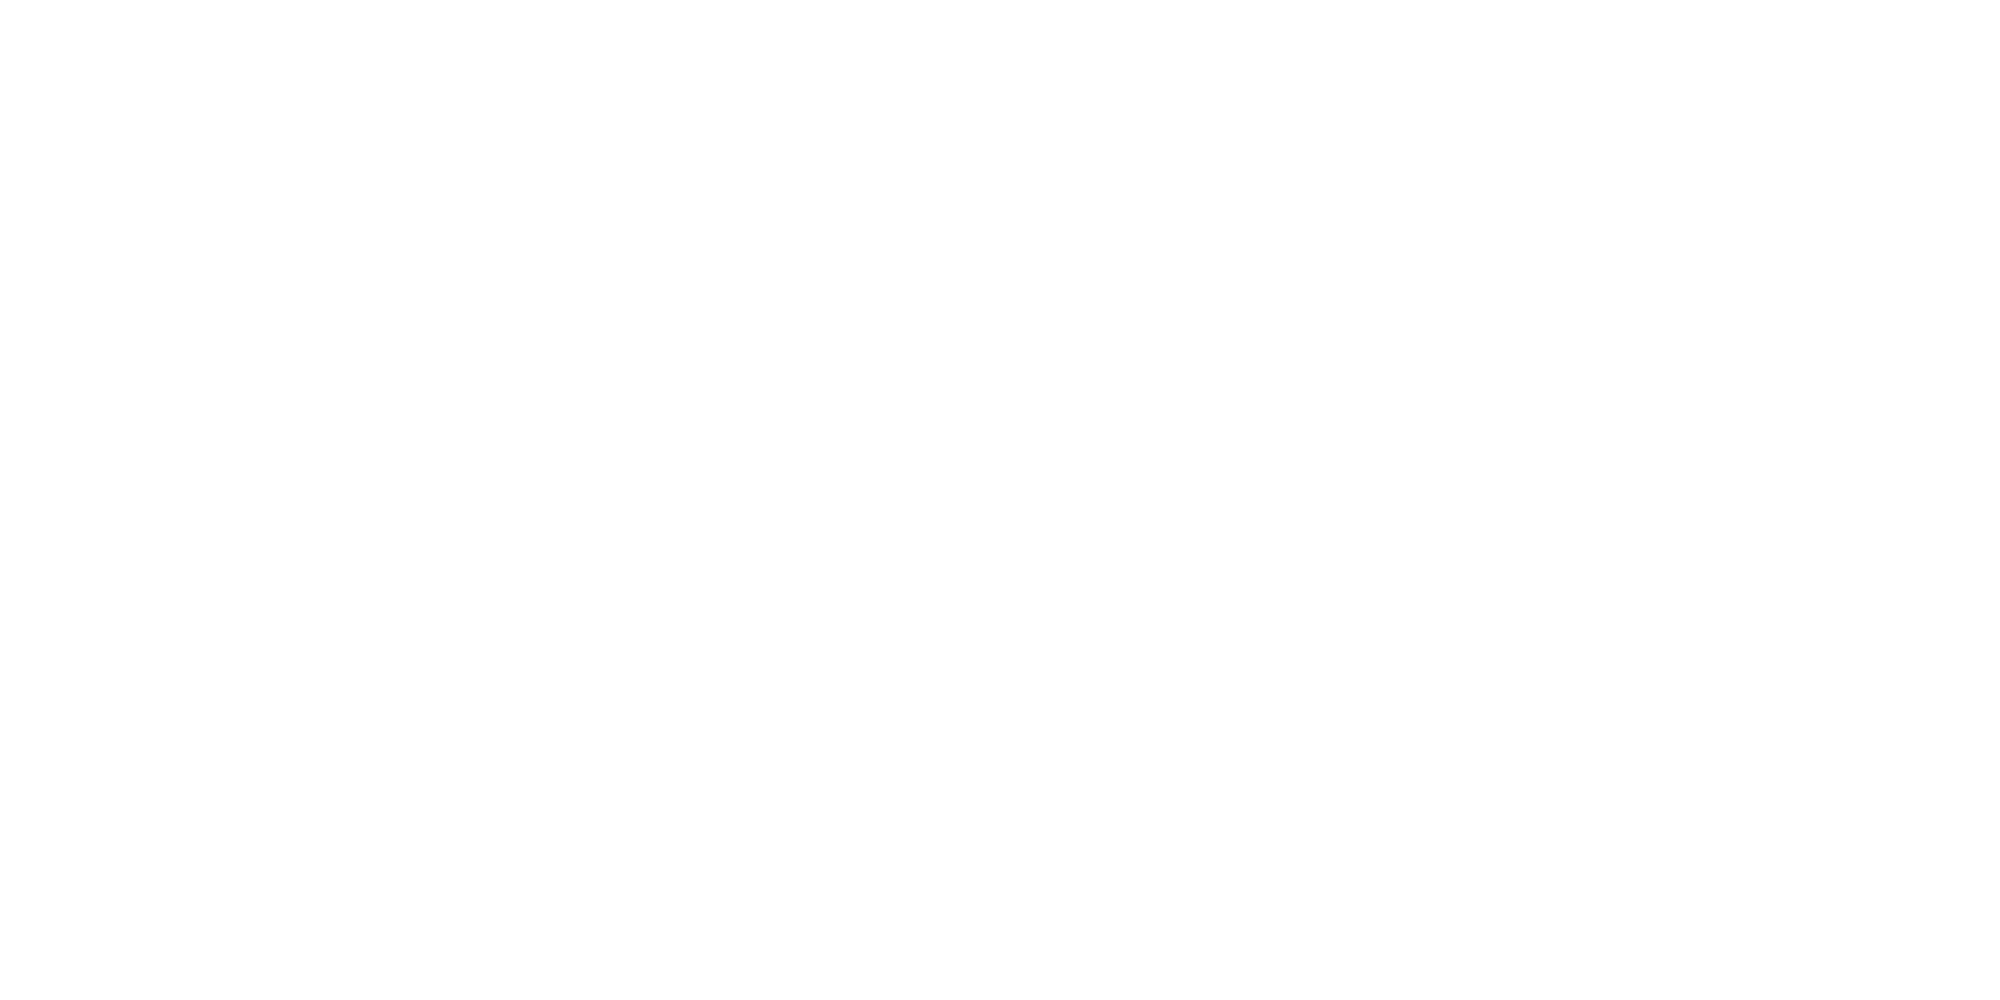

In [16]:
disparity_bm = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='bm')
disparity_sgbm = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='sgbm')
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.imshow(handler.first_image_left)
ax2.imshow(handler.first_image_right)
ax3.imshow(disparity_bm)
ax4.imshow(disparity_sgbm);

# Depth map from disparity

<img src="images/stereo_camera.png" width=500 height=500 />

using triangulation method, we get,

$$
  Z = \frac{f b}{d}
$$

$$
  d = x_L - x_R
$$

where, d is the disparity and $x_L$ and $x_R$ are difference in horizontal pixel location of the point projected onto the left and right image planes and b is the baseline.

openCV has 2 methods to calculate the disparity map:
1. bm
2. sgbm

sgbm performs better than bm but is comparitively slower

$$Z = \frac{f b}{d}$$

we will be using the above formula to calculate the depth image, here f is the f_x from the intrinsic matric, b is the baseline and d is the disparity map we get earlier

In [17]:
# to get parameters from the projection matrix
def decompose_projection_matrix(p):

    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t

In [18]:
def calc_depth_map(disparity_map, k_left, t_left, t_right, rectified=True):
    
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    if rectified:
        b = t_right[0] - t_left[0] 
    else:
        b = t_left[0] - t_right[0]
        
    # Avoid instability and division by zero
    disparity_map[disparity_map == 0.0] = 0.1
    disparity_map[disparity_map == -1.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disparity_map.shape)
    depth_map = f * b / disparity_map
    
    return depth_map

Now we will create a combined function that will calculate the disparity map and extract depth map from it. The steps are as follows:
1. calculate the disparity map between two left and right images
2. get the parameters f and b from the projection matrices
3. calculate the depth map by using the formula: 
$$Z = \frac{f b}{d}$$

In [19]:
# coding everything together
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rectified=True):
    
    # Compute disparity map
    disp = compute_left_disparity_map(img_left, 
                                      img_right, 
                                      matcher=matcher)
    # Decompose projection matrices
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    # Calculate depth map for left camera
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    
    return depth

In [20]:
depth_map = stereo_2_depth(handler.first_image_left,
                      handler.first_image_right,
                      handler.P0,
                      handler.P1,
                      matcher="sgbm",
                      rectified="True")

<IPython.core.display.Javascript object>


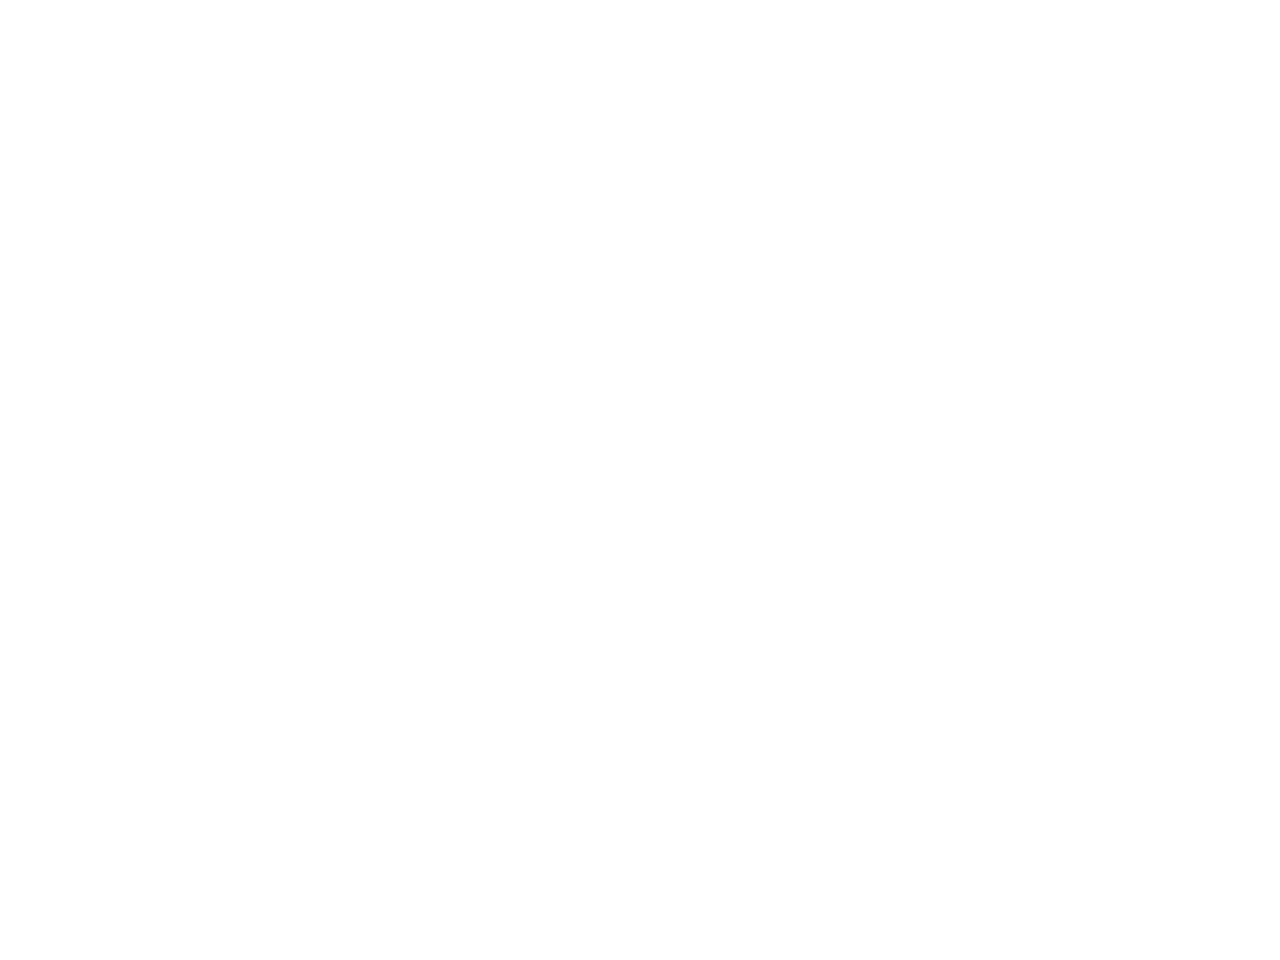

In [21]:
fig = plt.figure()
plt.imshow(depth_map);

In [22]:
print(depth_map.max())
depth_map[depth_map < 3000].max()

3861.447942459941


686.4796444444443

> NOTE: here, the pixel value 3861 corresponds to the disparity value 0 and -1, which means this depth value is not useful to us. Hence, a filter can be applied to remove this value from processing.

# Depth from pointclouds

> NOTE: although LIDAR is accurate but the pointcloud is sparse so we first found the depth from the stereo camera pairs

In [23]:
handler.first_pointcloud

array([[ 5.2897942e+01,  2.2989739e-02,  1.9979945e+00,  7.9999998e-02],
       [ 5.3750526e+01,  1.9291429e-01,  2.0269539e+00,  0.0000000e+00],
       [ 5.3803116e+01,  3.6183926e-01,  2.0289137e+00,  0.0000000e+00],
       ...,
       [ 3.8401384e+00, -1.4381756e+00, -1.7735560e+00,  3.4000000e-01],
       [ 3.8257158e+00, -1.4192016e+00, -1.7645701e+00,  2.5000000e-01],
       [ 4.0923753e+00, -1.5071962e+00, -1.8955611e+00,  0.0000000e+00]],
      dtype=float32)

In [24]:
def pointcloud2image(pointcloud, imheight, imwidth, Tr, P0):
    
    pointcloud = pointcloud[pointcloud[:, 0] > 0]
    reflectance = pointcloud[:, 3]
    # Make pointcloud homogeneous (X, Y, Z, 1)
    pointcloud = np.hstack([pointcloud[:, :3], np.ones(pointcloud.shape[0]).reshape((-1,1))])
    
    # Transform points into 3D coordinate frame of camera
    cam_xyz = Tr.dot(pointcloud.T)
    # Clip off negative z values
    cam_xyz = cam_xyz[:, cam_xyz[2] > 0]
    
    depth = cam_xyz[2].copy()
    
    cam_xyz /= cam_xyz[2]    
    cam_xyz = np.vstack([cam_xyz, np.ones(cam_xyz.shape[1])])
    projection = P0.dot(cam_xyz)
    pixel_coordinates = np.round(projection.T, 0)[:, :2].astype('int')
    
    indices = np.where((pixel_coordinates[:, 0] < imwidth)
                       & (pixel_coordinates[:, 0] >= 0)
                       & (pixel_coordinates[:, 1] < imheight)
                       & (pixel_coordinates[:, 1] >= 0))
    
    pixel_coordinates = pixel_coordinates[indices]
    depth = depth[indices]
    reflectance = reflectance[indices]
    
    render = np.zeros((imheight, imwidth))
    for j, (u, v) in enumerate(pixel_coordinates):
        render[v, u] = depth[j]
        
    return render

In [25]:
render = pointcloud2image(handler.first_pointcloud, 
                          handler.imheight,
                          handler.imwidth,
                          handler.Tr,
                          handler.P0
                         )

<IPython.core.display.Javascript object>


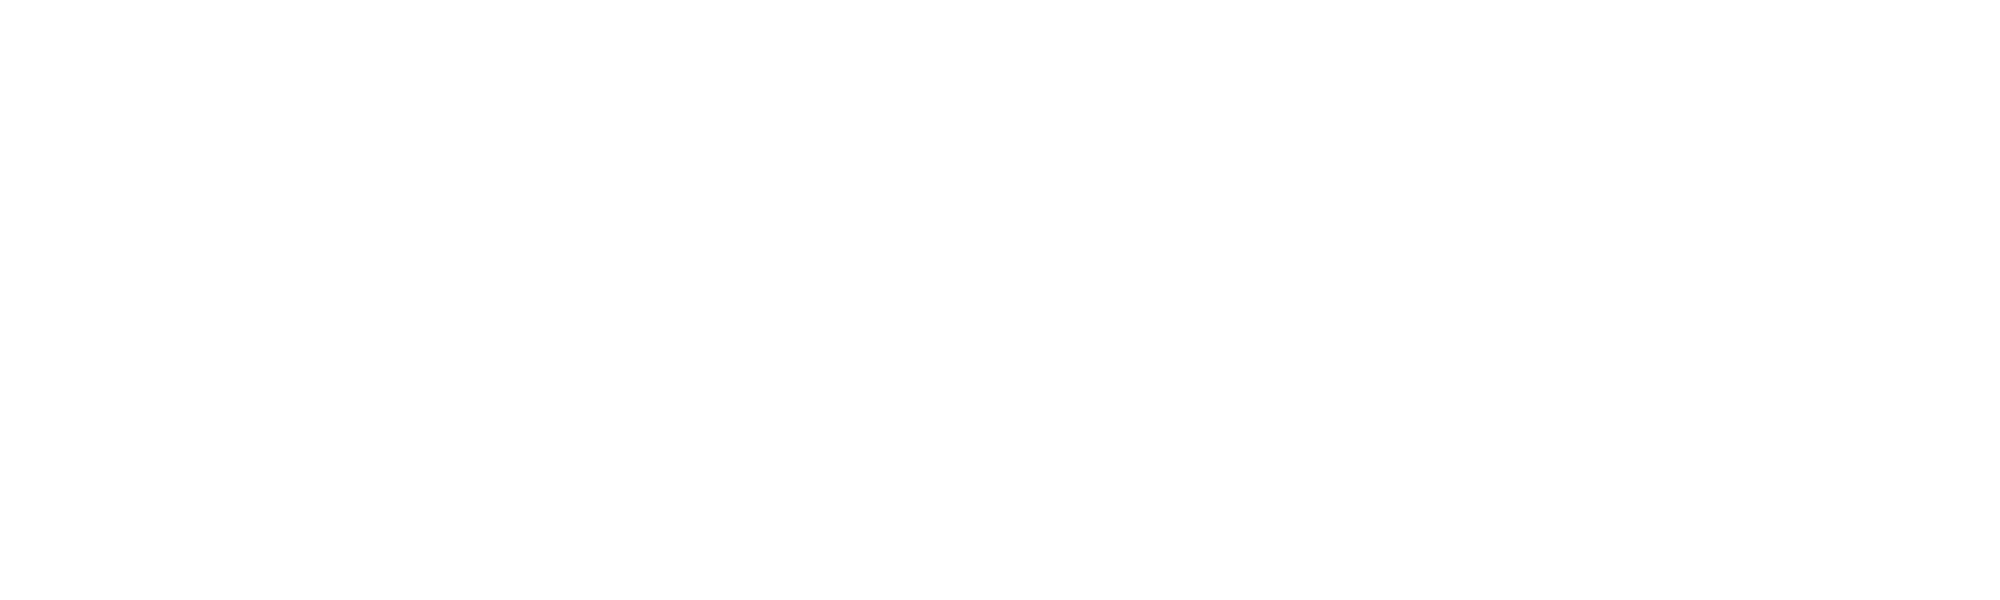

In [26]:
plt.figure(figsize=(10,3))
plt.imshow(render);

# Comparing the depth

comparing the depth values attained from the stereo camera and the pointclouds

In [27]:
counter = 0
for i in range(depth_map.shape[0]):
    for j in range(depth_map.shape[1]):
        if counter < 10:
            if render[i][j] > 0 and depth_map[i][j] != 3861.447942459941:
                print(depth_map[i][j], render[i][j])
                counter +=1

4.064682105263157 4.082927677078419
11.768222476190473 4.120294590980553
11.745849429657792 4.110687331964981
4.064682105263157 4.099315671169914
4.064682105263157 4.1157165271188605
11.701357575757573 4.124604063109464
11.701357575757573 4.099019064076344
4.064682105263157 4.092423873418519
4.064682105263157 4.098829136682579
4.064682105263157 4.090625286982059


In [28]:
handler.reset_frames
pcloud_frames = (pointcloud2image(next(handler.pointclouds),
                                  handler.imheight,
                                  handler.imwidth,
                                  handler.Tr,
                                  handler.P0)
                 for i in range(handler.num_frames))

In [29]:
for i in range(handler.num_frames // 50):
    cv2.imshow("lidar", next(pcloud_frames))
    cv2.waitKey(70)
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x3cc6be0) is not the object's thread (0x5588110).
Cannot move to target thread (0x3cc6be0)

QObject::moveToThread: Current thread (0x3cc6be0) is not the object's thread (0x5588110).
Cannot move to target thread (0x3cc6be0)

QObject::moveToThread: Current thread (0x3cc6be0) is not the object's thread (0x5588110).
Cannot move to target thread (0x3cc6be0)

QObject::moveToThread: Current thread (0x3cc6be0) is not the object's thread (0x5588110).
Cannot move to target thread (0x3cc6be0)

QObject::moveToThread: Current thread (0x3cc6be0) is not the object's thread (0x5588110).
Cannot move to target thread (0x3cc6be0)

QObject::moveToThread: Current thread (0x3cc6be0) is not the object's thread (0x5588110).
Cannot move to target thread (0x3cc6be0)

QObject::moveToThread: Current thread (0x3cc6be0) is not the object's thread (0x5588110).
Cannot move to target thread (0x3cc6be0)

QObject::moveToThread: Current thread (0x3cc6be0) is not the object's thread

# Visualizing

In [30]:
handler.reset_frames()
poses = (gt for gt in handler.gt)

<IPython.core.display.Javascript object>


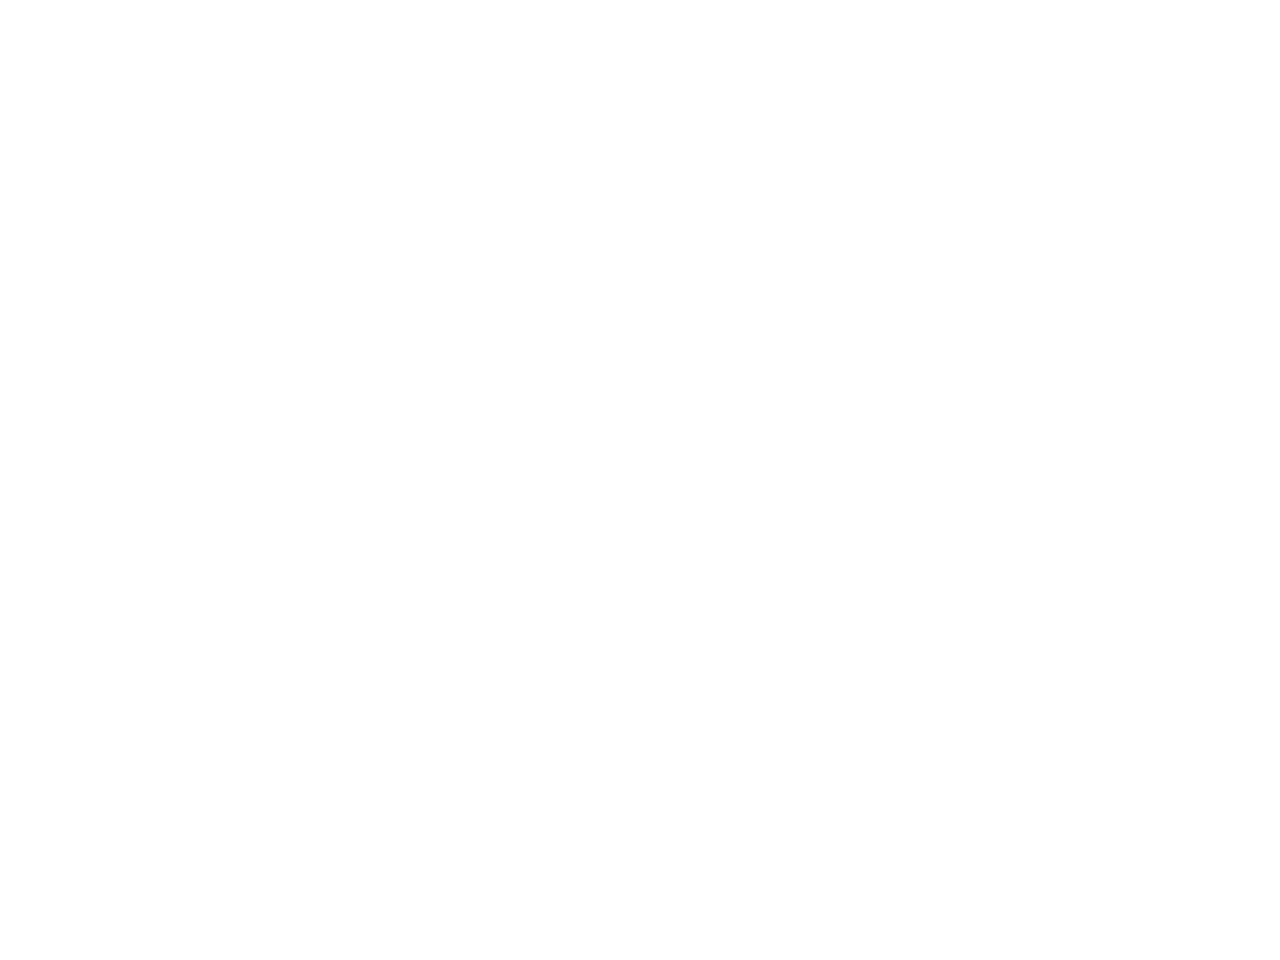

QObject::moveToThread: Current thread (0x3cc6be0) is not the object's thread (0x5588110).
Cannot move to target thread (0x3cc6be0)

QObject::moveToThread: Current thread (0x3cc6be0) is not the object's thread (0x5588110).
Cannot move to target thread (0x3cc6be0)

QObject::moveToThread: Current thread (0x3cc6be0) is not the object's thread (0x5588110).
Cannot move to target thread (0x3cc6be0)

QObject::moveToThread: Current thread (0x3cc6be0) is not the object's thread (0x5588110).
Cannot move to target thread (0x3cc6be0)

QObject::moveToThread: Current thread (0x3cc6be0) is not the object's thread (0x5588110).
Cannot move to target thread (0x3cc6be0)

QObject::moveToThread: Current thread (0x3cc6be0) is not the object's thread (0x5588110).
Cannot move to target thread (0x3cc6be0)

QObject::moveToThread: Current thread (0x3cc6be0) is not the object's thread (0x5588110).
Cannot move to target thread (0x3cc6be0)

QObject::moveToThread: Current thread (0x3cc6be0) is not the object's thread

/tmp/ipykernel_112805/664083915.py:44: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


In [31]:
xs = []
ys = []
zs = []
compute_times = []
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=-20, azim=270)
ax.plot(handler.gt[:, 0, 3], handler.gt[:, 1, 3], handler.gt[:, 2, 3], c='k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

stereo_l = handler.images_left
stereo_r = handler.images_right

for i in range(handler.num_frames // 50):
    img_l = next(stereo_l)
    img_r = next(stereo_r)
    start = datetime.datetime.now()
    disp = compute_left_disparity_map(img_l, img_r, matcher='sgbm')
    disp /= disp.max()
    #disp = 1 - disp
    disp = (disp*255).astype('uint8')
    #disp = cv2.applyColorMap(disp, cv2.COLORMAP_RAINBOW)
    pcloud = next(pcloud_frames)
    pcloud /= pcloud.max()
    pcloud = (pcloud*255).astype('uint8')
    
    
    gt = next(poses)
    xs.append(gt[0, 3])
    ys.append(gt[1, 3])
    zs.append(gt[2, 3])
    plt.plot(xs, ys, zs, c='chartreuse')
    plt.pause(0.000000000000000001)
    cv2.imshow('camera', img_l)
    cv2.imshow('disparity', disp)
    cv2.imshow('lidar', pcloud)
    cv2.waitKey(1)
    
    end = datetime.datetime.now()
    compute_times.append(end-start)
    
plt.close()
cv2.destroyAllWindows()

## Difference between color channels

plt.imread() : RGB \
cv2.imread() : BGR

# SIFT (Scale Invariant Feature Transform)

We want to reduce an image to a set of locally distinct points together with the description of these points. And, to find these points in another image if it is the image of the same scene with a different camera orientation.

<img src="images/sift1.png" width=500 height=500 />

These points are found out by using difference of gaussians approach, i.e. take your image and blur it using different gaussian kernels (different magnitude) then subsract these images from each other. Now we are looking for the extreme points that stand out and are the locally distinct points for that image. We also do this for different scales of the image by using the gaussian pyramid, to make it scale invariant.

To compute the descriptor vector, we take the local neighbourhood of these points and break it down into small areas. We take gradients because they are robust with the viewpoint changes and elimination changes. Now we collect these gradients into a histogram of gradients. So now the 4\*4 region will have 16 histograms, every histogram is discritized in 45 degree orientation that is 8 bins so now we have 128 values descriptor vector.

<img src="images/sift2.png" width=900 height=500 />

[SIFT with Cyrill Stachniss](https://www.youtube.com/watch?v=4AvTMVD9ig0)

## HOG (Histogram of Gradients)

<img src="images/hog1.jpg" width=1000 height=300 />

<img src="images/hog2.jpg" width=1000 height=200 />

<img src="images/hog3.jpg" width=1000 height=300 />

We will take the features in one frame at  get their 3D coordinates and then match these features to other corresponding frames and see how the camera position has changed relatively.

In [32]:
def extract_features(image, mask=None):
    
    det = cv2.SIFT_create()      
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

k: Count of best matches found per each query descriptor or less if a query descriptor has less than k possible matches in total.

In [33]:
def match_features(des1, des2, matching='BF', sort=True, k=2):

    if matching == 'BF':
        matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [34]:
def visualize_matches(image1, kp1, image2, kp2, match):
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

In [35]:
def filter_matches_distance(matches, dist_threshold):
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

In [36]:
%matplotlib inline

Number of matches before filtering: 2423
Number of matches after filtering: 678


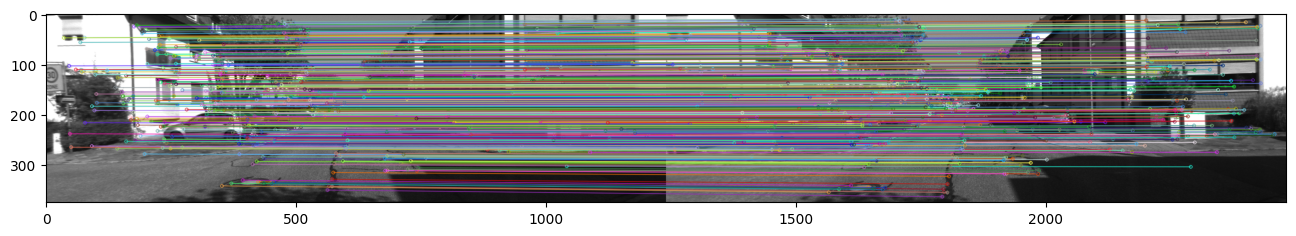

In [37]:
image_left = next(handler.images_left)
image_right = next(handler.images_right)
image_plus1 = next(handler.images_left)
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='sgbm')
kp0, des0 = extract_features(image_left)
kp1, des1 = extract_features(image_plus1)
matches = match_features(des0, des1, matching='BF', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

# RANSAC (Random sample consensus)

[RANSAC by Cyrill Stachniss](https://www.youtube.com/watch?v=9D5rrtCC_E0)

<img src="images/ransac1.png" width=200 height=100 />

<img src="images/ransac2.png" width=300 height=600 />

where, \
p = desired probability that the RANSAC algorithm provides at least one useful result after running \
e = number of inliers in data / number of points in data \
s = data points selected independently

Step 1: Take two random points and fit a line through it \
Step 2: Count the number of inliers and outliers for that line \
Step 3: Repeat this step T times and then take the solution which has max inliers

In [38]:
def estimate_motion(match, kp1, kp2, k, depth1=None, max_depth=3000):

    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])

    if depth1 is not None:
        cx = k[0, 2]
        cy = k[1, 2]
        fx = k[0, 0]
        fy = k[1, 1]
        object_points = np.zeros((0, 3))
        delete = []

        # Extract depth information of query image at match points and build 3D positions
        for i, (u, v) in enumerate(image1_points):
            z = depth1[int(v), int(u)]
            if z > max_depth:
                delete.append(i)
                continue
                
            # Use arithmetic to extract x and y (faster than using inverse of k)
            x = z*(u-cx)/fx
            y = z*(v-cy)/fy
            object_points = np.vstack([object_points, np.array([x, y, z])])
            # Equivalent math with dot product w/ inverse of k matrix, but SLOWER (see Appendix A)
            #object_points = np.vstack([object_points, np.linalg.inv(k).dot(z*np.array([u, v, 1]))])

        image1_points = np.delete(image1_points, delete, 0)
        image2_points = np.delete(image2_points, delete, 0)
        
        # Use PnP algorithm with RANSAC for robustness to outliers
        _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
        rmat = cv2.Rodrigues(rvec)[0]
    
    else:
        image1_points_hom = np.hstack([image1_points, np.ones(len(image1_points)).reshape(-1,1)])
        image2_points_hom = np.hstack([image2_points, np.ones(len(image2_points)).reshape(-1,1)])
        E = cv2.findEssentialMat(image1_points, image2_points, k)[0]
        _, rmat, tvec, mask = cv2.recoverPose(E, image1_points, image2_points, k)
    
    return rmat, tvec, image1_points, image2_points

First we will filter out the points where depth is less than 3000 and then pass these points with the correspponding points found out from SIFT to RANSAC to find out the inliers and get rotation matrix and translation vector from it.

In [39]:
k,r,t,_,_,_, _ = cv2.decomposeProjectionMatrix(handler.P0)

In [40]:
rmat, tvec, image1_points, image2_points = estimate_motion(matches, kp0, kp1, k, depth)

In [41]:
print("rotational matrix", rmat)
print("translational vector", tvec)

transformation_matrix = np.eye(4)
transformation_matrix[:3,:3] = rmat
transformation_matrix[:3,3] = tvec.T
print("transformation matrix",transformation_matrix)

rotational matrix [[ 0.9999568   0.00464522 -0.00805119]
 [-0.00467334  0.99998303 -0.00347725]
 [ 0.0080349   0.00351473  0.99996154]]
translational vector [[-0.01089053]
 [ 0.01550928]
 [-0.53309734]]
transformation matrix [[ 0.9999568   0.00464522 -0.00805119 -0.01089053]
 [-0.00467334  0.99998303 -0.00347725  0.01550928]
 [ 0.0080349   0.00351473  0.99996154 -0.53309734]
 [ 0.          0.          0.          1.        ]]


> NOTE: This transformation matrix tells where the camera is in the first frame wrt to the second frame (i.e. it is going backwards), while we want to know where the camera is in the second frame wrt the camera in the first frame (i.e. going forward). So when using it, we wil have to use the inverse of this matrix.

# Visual Odometry

In [ ]:
def visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=None,
                    stereo_matcher='sgbm', mask=None, subset=None, plot=False):
    # Determine if handler has lidar data
    lidar = handler.lidar
    
    # Report methods being used to user
    print('Generating disparities with Stereo{}'.format(str.upper(stereo_matcher)))
    print('Detecting features with {} and matching with {}'.format(str.upper(detector),
                                                                  matching))
    if filter_match_distance is not None:
        print('Filtering feature matches at threshold of {}*distance'.format(filter_match_distance))
    if lidar:
        print('Improving stereo depth estimation with lidar data')
    if subset is not None:
        num_frames = subset
    else:
        num_frames = handler.num_frames
        
    if plot:
        fig = plt.figure(figsize=(25, 20))
        ax = fig.add_subplot(projection='3d')
        ax.view_init(elev=-20, azim=270)
        xs = handler.gt[:, 0, 3]
        ys = handler.gt[:, 1, 3]
        zs = handler.gt[:, 2, 3]
        ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
        ax.plot(xs, ys, zs, c='k', markersize=0.9)
        
    # Establish a homogeneous transformation matrix. First pose is identity
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    imheight = handler.imheight
    imwidth = handler.imwidth
    
    # Decompose left camera projection matrix to get intrinsic k matrix
    k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
    
    handler.reset_frames()
    image_plus1 = next(handler.images_left)
        
    # Iterate through all frames of the sequence
    for i in range(num_frames - 1):
        start = datetime.datetime.now()
        

        image_left = image_plus1
        image_plus1 = next(handler.images_left)
        image_right = next(handler.images_right)

            
        depth = stereo_2_depth(image_left,
                               image_right,
                               P0=handler.P0,
                               P1=handler.P1,
                               matcher=stereo_matcher
                              )
        
        if lidar:

            pointcloud = next(handler.pointclouds)
            
            lidar_depth = pointcloud2image(pointcloud,
                                           imheight=imheight,
                                           imwidth=imwidth,
                                           Tr=handler.Tr,
                                           P0=handler.P0
                                          )
            indices = np.where(lidar_depth > 0)
            depth[indices] = lidar_depth[indices]
            
        # Get keypoints and descriptors for left camera image of two sequential frames
        kp0, des0 = extract_features(image_left)
        kp1, des1 = extract_features(image_plus1)
        
        # Get matches between features detected in two subsequent frames
        matches_unfilt = match_features(des0, 
                                        des1,
                                        matching=matching,
                                       )
        #print('Number of features before filtering: ', len(matches_unfilt))
        
        # Filter matches if a distance threshold is provided by user
        if filter_match_distance is not None:
            matches = filter_matches_distance(matches_unfilt, filter_match_distance)
        else:
            matches = matches_unfilt
            
        
        #print('Number of features after filtering: ', len(matches))
        #print('Length of kp0:', len(kp0))
        #print('Length of kp1:', len(kp1))
            
        # Estimate motion between sequential images of the left camera
        rmat, tvec, img1_points, img2_points = estimate_motion(matches,
                                                               kp0,
                                                               kp1,
                                                               k_left,
                                                               depth
                                                              )
        
        # Create a blank homogeneous transformation matrix
        Tmat = np.eye(4)
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T
        
        T_tot = T_tot.dot(np.linalg.inv(Tmat))
        
        trajectory[i+1, :, :] = T_tot[:3, :]
        
        end = datetime.datetime.now()
        print('Time to compute frame {}:'.format(i+1), end-start)
        
        if plot:
            xs = trajectory[:i+2, 0, 3]
            ys = trajectory[:i+2, 1, 3]
            zs = trajectory[:i+2, 2, 3]
            plt.plot(xs, ys, zs, c='r', markersize=0.9)
            plt.pause(1e-32)
            
        
    return trajectory

> NOTE: accumulating all the transformations i.e. position of 3rd frame wrt the 1st frame as the transformations multiplied give combined transformations

In [66]:
import matplotlib
matplotlib.use("TkAgg")

In [ ]:
trajectory = visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=0.3, 
                    stereo_matcher='sgbm', mask=None, subset=None,
                    plot=True)
plt.close()

Generating disparities with StereoSGBM
Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.3*distance
Improving stereo depth estimation with lidar data
Time to compute frame 1: 0:00:00.219954
Time to compute frame 2: 0:00:00.287123
Time to compute frame 3: 0:00:00.234884
Time to compute frame 4: 0:00:00.207097
Time to compute frame 5: 0:00:00.204064
Time to compute frame 6: 0:00:00.208385
Time to compute frame 7: 0:00:00.202743
Time to compute frame 8: 0:00:00.210250
Time to compute frame 9: 0:00:00.231164
Time to compute frame 10: 0:00:00.200811
Time to compute frame 11: 0:00:00.199024
Time to compute frame 12: 0:00:00.190363
Time to compute frame 13: 0:00:00.218671
Time to compute frame 14: 0:00:00.182508
Time to compute frame 15: 0:00:00.208604
Time to compute frame 16: 0:00:00.206484
Time to compute frame 17: 0:00:00.193420
Time to compute frame 18: 0:00:00.222055
Time to compute frame 19: 0:00:00.243779
Time to compute frame 20: 0:00:00.22

Time to compute frame 195: 0:00:00.240383
Time to compute frame 196: 0:00:00.234104
Time to compute frame 197: 0:00:00.223376
Time to compute frame 198: 0:00:00.227264
Time to compute frame 199: 0:00:00.232196
Time to compute frame 200: 0:00:00.240260
Time to compute frame 201: 0:00:00.247383
Time to compute frame 202: 0:00:00.230428
Time to compute frame 203: 0:00:00.237945
Time to compute frame 204: 0:00:00.236858
Time to compute frame 205: 0:00:00.231342
Time to compute frame 206: 0:00:00.242369
Time to compute frame 207: 0:00:00.245547
Time to compute frame 208: 0:00:00.210670
Time to compute frame 209: 0:00:00.221970
Time to compute frame 210: 0:00:00.247822
Time to compute frame 211: 0:00:00.240137
Time to compute frame 212: 0:00:00.234600
Time to compute frame 213: 0:00:00.210366
Time to compute frame 214: 0:00:00.197545
Time to compute frame 215: 0:00:00.205199
Time to compute frame 216: 0:00:00.237850
Time to compute frame 217: 0:00:00.235711
Time to compute frame 218: 0:00:00

Time to compute frame 391: 0:00:00.248191
Time to compute frame 392: 0:00:00.210201
Time to compute frame 393: 0:00:00.235109
Time to compute frame 394: 0:00:00.216522
Time to compute frame 395: 0:00:00.316367
Time to compute frame 396: 0:00:00.236031
Time to compute frame 397: 0:00:00.196228
Time to compute frame 398: 0:00:00.237939
Time to compute frame 399: 0:00:00.185336
Time to compute frame 400: 0:00:00.198616
Time to compute frame 401: 0:00:00.209290
Time to compute frame 402: 0:00:00.196798
Time to compute frame 403: 0:00:00.193892
Time to compute frame 404: 0:00:00.202666
Time to compute frame 405: 0:00:00.216422
Time to compute frame 406: 0:00:00.231081
Time to compute frame 407: 0:00:00.194562
Time to compute frame 408: 0:00:00.190406
Time to compute frame 409: 0:00:00.206806
Time to compute frame 410: 0:00:00.216471
Time to compute frame 411: 0:00:00.186835
Time to compute frame 412: 0:00:00.192472
Time to compute frame 413: 0:00:00.234572
Time to compute frame 414: 0:00:00

Time to compute frame 587: 0:00:00.225401
Time to compute frame 588: 0:00:00.241861
Time to compute frame 589: 0:00:00.232027
Time to compute frame 590: 0:00:00.266067
Time to compute frame 591: 0:00:00.313612
Time to compute frame 592: 0:00:00.236402
Time to compute frame 593: 0:00:00.280801
Time to compute frame 594: 0:00:00.241665
Time to compute frame 595: 0:00:00.228144
Time to compute frame 596: 0:00:00.273977
Time to compute frame 597: 0:00:00.234722
Time to compute frame 598: 0:00:00.229646
Time to compute frame 599: 0:00:00.238370
Time to compute frame 600: 0:00:00.278364
Time to compute frame 601: 0:00:00.281640
Time to compute frame 602: 0:00:00.257302
Time to compute frame 603: 0:00:00.217707
Time to compute frame 604: 0:00:00.260924
Time to compute frame 605: 0:00:00.225709
Time to compute frame 606: 0:00:00.251769
Time to compute frame 607: 0:00:00.252737
Time to compute frame 608: 0:00:00.254783
Time to compute frame 609: 0:00:00.255899
Time to compute frame 610: 0:00:00

Time to compute frame 783: 0:00:00.243601
Time to compute frame 784: 0:00:00.264650
Time to compute frame 785: 0:00:00.241829
Time to compute frame 786: 0:00:00.253725
Time to compute frame 787: 0:00:00.260129
Time to compute frame 788: 0:00:00.236379
Time to compute frame 789: 0:00:00.222963
Time to compute frame 790: 0:00:00.234270
Time to compute frame 791: 0:00:00.220731
Time to compute frame 792: 0:00:00.268631
Time to compute frame 793: 0:00:00.266205
Time to compute frame 794: 0:00:00.259537
Time to compute frame 795: 0:00:00.296979
Time to compute frame 796: 0:00:00.252540
Time to compute frame 797: 0:00:00.242046
Time to compute frame 798: 0:00:00.247463
Time to compute frame 799: 0:00:00.252730
Time to compute frame 800: 0:00:00.250521
Time to compute frame 801: 0:00:00.336500
Time to compute frame 802: 0:00:00.294875
Time to compute frame 803: 0:00:00.231248
Time to compute frame 804: 0:00:00.237297
Time to compute frame 805: 0:00:00.263499
Time to compute frame 806: 0:00:00

Time to compute frame 979: 0:00:00.222475
Time to compute frame 980: 0:00:00.240872
Time to compute frame 981: 0:00:00.241824
Time to compute frame 982: 0:00:00.235502
Time to compute frame 983: 0:00:00.241676
Time to compute frame 984: 0:00:00.241213
Time to compute frame 985: 0:00:00.239750
Time to compute frame 986: 0:00:00.237325
Time to compute frame 987: 0:00:00.240462
Time to compute frame 988: 0:00:00.239927
Time to compute frame 989: 0:00:00.245333
Time to compute frame 990: 0:00:00.225599
Time to compute frame 991: 0:00:00.217978
Time to compute frame 992: 0:00:00.230314
Time to compute frame 993: 0:00:00.241215
Time to compute frame 994: 0:00:00.228481
Time to compute frame 995: 0:00:00.227305
Time to compute frame 996: 0:00:00.218017
Time to compute frame 997: 0:00:00.239803
Time to compute frame 998: 0:00:00.260165
Time to compute frame 999: 0:00:00.253385
Time to compute frame 1000: 0:00:00.251718
Time to compute frame 1001: 0:00:00.260160
Time to compute frame 1002: 0:00

Time to compute frame 1171: 0:00:00.259671
Time to compute frame 1172: 0:00:00.256570
Time to compute frame 1173: 0:00:00.246032
Time to compute frame 1174: 0:00:00.248596
Time to compute frame 1175: 0:00:00.260818
Time to compute frame 1176: 0:00:00.233717
Time to compute frame 1177: 0:00:00.250038
Time to compute frame 1178: 0:00:00.264666
Time to compute frame 1179: 0:00:00.243677
Time to compute frame 1180: 0:00:00.242863
Time to compute frame 1181: 0:00:00.257983
Time to compute frame 1182: 0:00:00.390917
Time to compute frame 1183: 0:00:00.258899
Time to compute frame 1184: 0:00:00.280285
Time to compute frame 1185: 0:00:00.269072
Time to compute frame 1186: 0:00:00.264469
Time to compute frame 1187: 0:00:00.276895
Time to compute frame 1188: 0:00:00.266445
Time to compute frame 1189: 0:00:00.279216
Time to compute frame 1190: 0:00:00.287100
Time to compute frame 1191: 0:00:00.276903
Time to compute frame 1192: 0:00:00.278399
Time to compute frame 1193: 0:00:00.247216
Time to com

## Visualizing the visu
<img src="images/visual_odometry_plt.png" width=300 height=600 />